# LDA: (Harmonic) Linear Discriminant Analysis 

### Import

In [31]:
# IMPORT PACKAGES
import torch
import numpy as np
import matplotlib.pyplot as plt

# IMPORT HELPER FUNCTIONS
from mlcolvar.utils.plot import muller_brown_potential, plot_isolines_2D

# Set seed for reproducibility
torch.manual_seed(42)

## Muller-Brown potential (2 states)

### Load MD data

In [32]:
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictionaryDataModule

n_states = 2
filenames = [ f"data/muller-brown/unbiased/state-{i}/COLVAR" for i in range(n_states) ]

# load dataset
dataset, df = create_dataset_from_files(filenames,return_dataframe=True, filter_args={'regex':'p.x|p.y'})

Class 0 dataframe shape:  (2001, 12)
Class 1 dataframe shape:  (2001, 12)

 - Loaded dataframe (4002, 12): ['time', 'p.x', 'p.y', 'p.z', 'ene', 'pot.bias', 'pot.ene_bias', 'lwall.bias', 'lwall.force2', 'uwall.bias', 'uwall.force2', 'labels']
 - Descriptors (4002, 2): ['p.x', 'p.y']


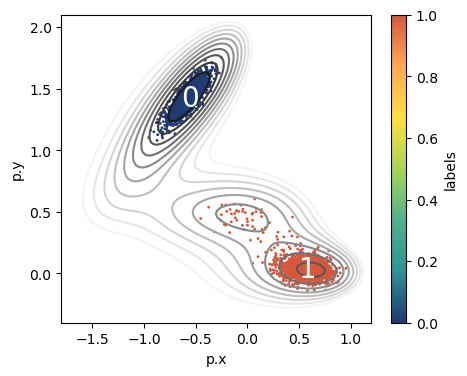

In [33]:
fig,ax = plt.subplots(figsize=(5,4),dpi=100)
# ploy MB isolines
plot_isolines_2D(muller_brown_potential,mode='contour',levels=np.linspace(0,24,12),ax=ax)
# plot points colored according to labels
df.plot.scatter('p.x','p.y',c='labels',s=1,cmap='fessa',ax=ax)
# draw state labels
for i in range(n_states):
    df_g = df.groupby('labels').mean()
    ax.text(x = df_g['p.x'].values[i]-0.075, 
            y = df_g['p.y'].values[i]-0.075,
            s = str(i), size=20, color='white')


### Prepare dataset

In [34]:
# get inputs X and labels
X = dataset[:]['data']
labels = dataset[:]['labels']

print('X:',X.shape)
print('labels:',labels.shape)

X: torch.Size([4002, 2])
labels: torch.Size([4002])


### Compute LDA

In [35]:
from mlcolvar.core.stats import LDA

# define LDA object 
lda = LDA(in_features=X.shape[1], n_states=n_states,mode='standard')

# compute vectors that most discriminate the states
eigvals, eigvecs = lda.compute(X,labels)

### Get eigenvector coefficients

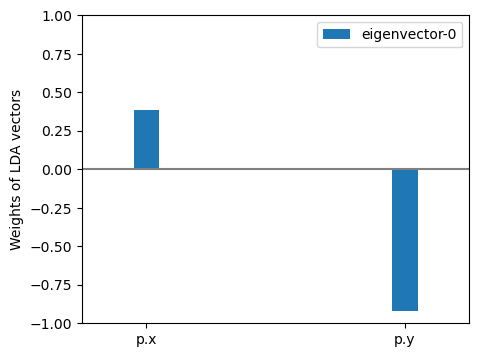

In [37]:
# inspect eigenvector(s)
fig,ax = plt.subplots(figsize=(5,4),dpi=100)

for i in range(n_states-1):
    eigvec = eigvecs[:,i]
    ax.bar(np.arange(len(eigvec))+0.1*i,eigvec,width=0.1, label=f'eigenvector-{i}')

ax.set_ylabel('Weights of LDA vectors')
ax.axhline(0,c='grey')
ax.set_xticks([0,1])
ax.set_xticklabels(['p.x','p.y'])
ax.set_xlim(-0.25,1.25)
ax.set_ylim(-1,1)
ax.legend()
plt.show()


### Visualize CV isolines

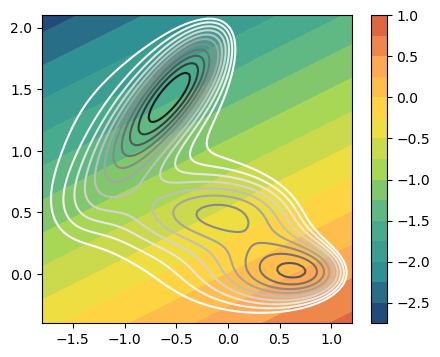

In [38]:
# Inspect linear combination vs potential
n_components=n_states-1
fig,axs = plt.subplots( 1, n_components, figsize=(5*n_components,4) )
if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]
    plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
    plot_isolines_2D(lda, component=i, levels=15, ax=ax)

### Harmonic version: HLDA

In [39]:
# define HLDA object 
hlda = LDA(in_features=X.shape[1], n_states=n_states, mode='harmonic')

# compute vectors that most discriminate the states
eigvals, eigvecs = hlda.compute(X,labels)

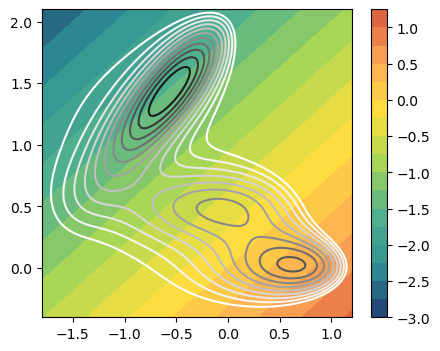

In [40]:
# Inspect linear combination vs potential
n_components=n_states-1
fig,axs = plt.subplots( 1, n_components, figsize=(5*n_components,4) )
if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]
    plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
    plot_isolines_2D(hlda, component=i, levels=15, ax=ax)

## Modified Muller-Brown (3 states)

### Define custom potential function

In [41]:
def modified_muller_brown_potential(x,y):
    prefactor = 0.15
    A=(-280,-170,-170,15)
    a=(-15,-1,-6.5,0.7)
    b=(0,0,11,0.6)
    c=(-10,-10,-6.5,0.7)
    x0=(1,0.2,-0.5,-1)
    y0=(0,0.5,1.5,1)
    offset = -146.7

    v = -prefactor*offset
    for i in range(4):
        v += prefactor * A[i]*np.exp( a[i]*(x-x0[i])**2 + b[i]*(x-x0[i])*(y-y0[i]) + c[i]*(y-y0[i])**2 )
    return v

### Load data

In [42]:
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictionaryDataModule

n_states = 3
filenames = [ f"data/muller-brown-3states/unbiased/state-{i}/COLVAR" for i in range(n_states) ]

# load dataset
dataset, df = create_dataset_from_files(filenames,return_dataframe=True, filter_args={'regex':'p.x|p.y'})

Class 0 dataframe shape:  (2001, 12)
Class 1 dataframe shape:  (2001, 12)
Class 2 dataframe shape:  (2001, 12)

 - Loaded dataframe (6003, 12): ['time', 'p.x', 'p.y', 'p.z', 'ene', 'pot.bias', 'pot.ene_bias', 'lwall.bias', 'lwall.force2', 'uwall.bias', 'uwall.force2', 'labels']
 - Descriptors (6003, 2): ['p.x', 'p.y']


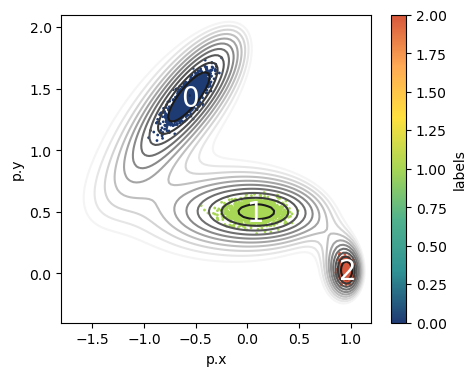

In [43]:
fig,ax = plt.subplots(figsize=(5,4),dpi=100)
# ploy MB isolines
plot_isolines_2D(modified_muller_brown_potential,mode='contour',levels=np.linspace(0,24,12),ax=ax)
# plot points colored according to labels
df.plot.scatter('p.x','p.y',c='labels',s=1,cmap='fessa',ax=ax)
# draw state labels
for i in range(n_states):
    df_g = df.groupby('labels').mean()
    ax.text(x = df_g['p.x'].values[i]-0.075, 
            y = df_g['p.y'].values[i]-0.075,
            s = str(i), size=20, color='white')


### Prepare dataset

In [44]:
# get inputs X and labels
X = dataset[:]['data']
labels = dataset[:]['labels']

print('X:',X.shape)
print('labels:',labels.shape)

X: torch.Size([6003, 2])
labels: torch.Size([6003])


### Compute HLDA

In [45]:
from mlcolvar.core.stats import LDA

# define LDA object 
lda = LDA(in_features=X.shape[1], n_states=n_states, mode='harmonic')

# compute vectors that most discriminate the states
eigvals, eigvecs = lda.compute(X,labels)

### Get eigenvector coefficients

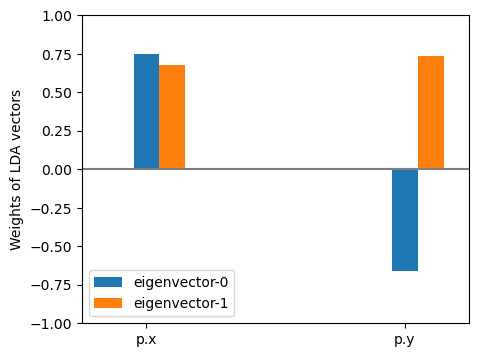

In [46]:
# inspect eigenvector(s)
fig,ax = plt.subplots(figsize=(5,4),dpi=100)

for i in range(n_states-1):
    eigvec = eigvecs[:,i]
    ax.bar(np.arange(len(eigvec))+0.1*i,eigvec,width=0.1, label=f'eigenvector-{i}')

ax.set_ylabel('Weights of LDA vectors')
ax.axhline(0,c='grey')
ax.set_xticks([0,1])
ax.set_xticklabels(['p.x','p.y'])
ax.set_xlim(-0.25,1.25)
ax.set_ylim(-1,1)
ax.legend()
plt.show()


### View CVs isolines

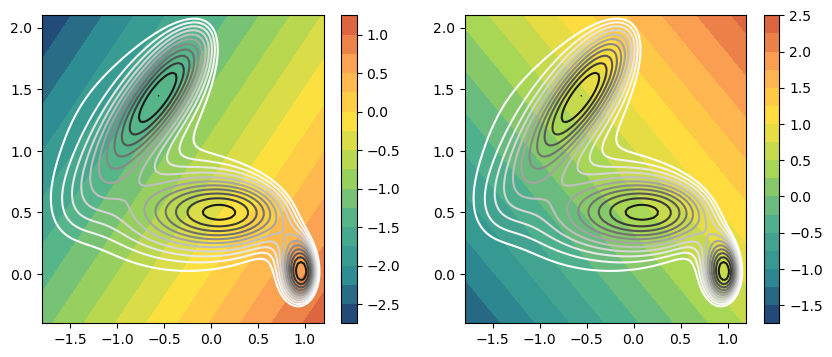

In [47]:
# Inspect linear combination vs potential
n_components=n_states-1
fig,axs = plt.subplots( 1, n_components, figsize=(5*n_components,4) )
if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]
    plot_isolines_2D(modified_muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
    plot_isolines_2D(lda, component=i, levels=15, ax=ax)

### View projected states

<AxesSubplot:xlabel='CV0', ylabel='CV1'>

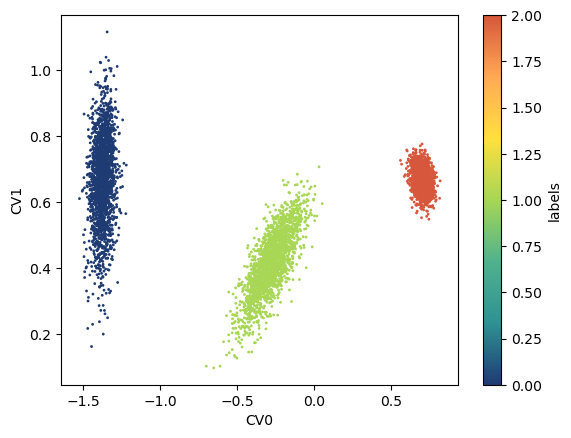

In [48]:
with torch.no_grad():
    s = lda(X).numpy()

for i in range(n_components):
    df[f'CV{i}'] = s[:,i]

df.plot.scatter('CV0','CV1',c='labels',cmap='fessa',s=1)